##Import Library##

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
# Inisialisasi SparkSession
spark = SparkSession.builder.appName("PenyakitParu-paru").getOrCreate()

In [ ]:
# Membaca data
file_path = "/content/predic_tabel.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

##Pre-processing Data##

In [ ]:
# Menampilkan ringkasan data
data.printSchema()
data.show(5)

root
 |-- No: integer (nullable = true)
 |-- Usia: string (nullable = true)
 |-- Jenis_Kelamin: string (nullable = true)
 |-- Merokok: string (nullable = true)
 |-- Bekerja: string (nullable = true)
 |-- Rumah_Tangga: string (nullable = true)
 |-- Aktivitas_Begadang: string (nullable = true)
 |-- Aktivitas_Olahraga: string (nullable = true)
 |-- Asuransi: string (nullable = true)
 |-- Penyakit_Bawaan: string (nullable = true)
 |-- Hasil: string (nullable = true)

+---+----+-------------+-------+-------+------------+------------------+------------------+--------+---------------+-----+
| No|Usia|Jenis_Kelamin|Merokok|Bekerja|Rumah_Tangga|Aktivitas_Begadang|Aktivitas_Olahraga|Asuransi|Penyakit_Bawaan|Hasil|
+---+----+-------------+-------+-------+------------+------------------+------------------+--------+---------------+-----+
|  1| Tua|         Pria|  Pasif|  Tidak|          Ya|                Ya|            Sering|     Ada|          Tidak|   Ya|
|  2| Tua|         Pria|  Aktif|  Tidak|

In [ ]:
# Mengganti nama kolom untuk konsistensi
from pyspark.ml.feature import StringIndexer, VectorAssembler


# Reload the data and rename columns
data = spark.read.csv(file_path, header=True, inferSchema=True)
columns_renamed = {
    'No': 'no',
    'Usia': 'usia',
    'Jenis_Kelamin': 'jenis_kelamin',
    'Merokok': 'merokok',
    'Bekerja': 'bekerja',
    'Rumah_Tangga': 'rumah_tangga',
    'Aktivitas_Begadang': 'aktivitas_begadang',
    'Aktivitas_Olahraga': 'aktivitas_olahraga',
    'Asuransi': 'asuransi',
    'Penyakit_Bawaan': 'penyakit_bawaan',
    'Hasil': 'hasil'
}
for old_col, new_col in columns_renamed.items():
    data = data.withColumnRenamed(old_col, new_col)

# Define categorical_columns here with the columns you want to encode
categorical_columns = ['usia', 'merokok','hasil']

# Encoding Fitur Kategorikal
categorical_columns = [col for col in categorical_columns if col != 'hasil']  # Exclude 'hasil' from features

# Use the renamed column names in StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_columns]
for indexer in indexers:
    data = indexer.fit(data).transform(data)

# Create feature vector after creating indexed columns
feature_cols = [f"{col}_index" for col in categorical_columns if col != 'hasil']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

In [ ]:
data_list = [
    ('Tua', 'Ya', 1),
    ('Muda', 'Tidak', 0),
    ('Muda', 'Ya', 1),
    ('Tua', 'Tidak', 0)
]
columns = ['Usia', 'Merokok', 'Hasil']
df = spark.createDataFrame(data_list, columns)

# Encoding kolom string menjadi numerik
indexer_age = StringIndexer(inputCol="Usia", outputCol="Usia_index")
indexer_smoking = StringIndexer(inputCol="Merokok", outputCol="Merokok_index")

df_encoded = indexer_age.fit(df).transform(df)
df_encoded = indexer_smoking.fit(df_encoded).transform(df_encoded)

# Pilih kolom fitur dan target
df_features = df_encoded.select("Usia_index", "Merokok_index", "Hasil")

# Konversi PySpark DataFrame ke Pandas DataFrame
df_pandas = df_features.toPandas()

# Pisahkan fitur (X) dan target (y)
X = df_pandas.drop(columns=["Hasil"])
y = df_pandas["Hasil"]

# Assign 'data' to 'data_asli' before renaming the column
data_asli = data

# Rename the 'Hasil' column in the original PySpark DataFrame
data_asli = data_asli.withColumnRenamed("Hasil", "label")
indexer_label = StringIndexer(inputCol="label", outputCol="label_index")




indexer_age = StringIndexer(inputCol="usia", outputCol="Usia_index")
# Update inputCol to 'merokok' for indexer_smoking
indexer_smoking = StringIndexer(inputCol="merokok", outputCol="Merokok_index")

data_asli_encoded = indexer_age.fit(data_asli).transform(data_asli)
data_asli_encoded = indexer_smoking.fit(data_asli_encoded).transform(data_asli_encoded)
# Terapkan encoding untuk kolom "label"
# Now apply the encoding for the "label" column
data_asli_encoded = indexer_label.fit(data_asli_encoded).transform(data_asli_encoded)

data_asli_encoded.show(5)

+---+----+-------------+-------+-------+------------+------------------+------------------+--------+---------------+-----+----------+-------------+---------+-----------+
| no|usia|jenis_kelamin|merokok|bekerja|rumah_tangga|aktivitas_begadang|aktivitas_olahraga|asuransi|penyakit_bawaan|label|Usia_index|Merokok_index| features|label_index|
+---+----+-------------+-------+-------+------------+------------------+------------------+--------+---------------+-----+----------+-------------+---------+-----------+
|  1| Tua|         Pria|  Pasif|  Tidak|          Ya|                Ya|            Sering|     Ada|          Tidak|   Ya|       1.0|          1.0|[1.0,1.0]|        1.0|
|  2| Tua|         Pria|  Aktif|  Tidak|          Ya|                Ya|            Jarang|     Ada|            Ada|Tidak|       1.0|          0.0|[1.0,0.0]|        0.0|
|  3|Muda|         Pria|  Aktif|  Tidak|          Ya|                Ya|            Jarang|     Ada|          Tidak|Tidak|       0.0|          0.0|(2,

In [ ]:
# Menampilkan Summary
data_asli_encoded.summary().show()

+-------+-----------------+-----+-------------+-------+-------+------------+------------------+------------------+--------+---------------+-----+-------------------+------------------+------------------+
|summary|               no| usia|jenis_kelamin|merokok|bekerja|rumah_tangga|aktivitas_begadang|aktivitas_olahraga|asuransi|penyakit_bawaan|label|         Usia_index|     Merokok_index|       label_index|
+-------+-----------------+-----+-------------+-------+-------+------------+------------------+------------------+--------+---------------+-----+-------------------+------------------+------------------+
|  count|            30000|30000|        30000|  30000|  30000|       30000|             30000|             30000|   30000|          30000|30000|              30000|             30000|             30000|
|   mean|          15000.5| NULL|         NULL|   NULL|   NULL|        NULL|              NULL|              NULL|    NULL|           NULL| NULL|0.48723333333333335|             0.493|

In [ ]:
# Menangani nilai null
numeric_cols = [c for c in data.columns if c != 'features']
null_counts = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_cols])
null_counts.show()

+---+----+-------------+-------+-------+------------+------------------+------------------+--------+---------------+-----+----------+-------------+
| no|usia|jenis_kelamin|merokok|bekerja|rumah_tangga|aktivitas_begadang|aktivitas_olahraga|asuransi|penyakit_bawaan|hasil|usia_index|merokok_index|
+---+----+-------------+-------+-------+------------+------------------+------------------+--------+---------------+-----+----------+-------------+
|  0|   0|            0|      0|      0|           0|                 0|                 0|       0|              0|    0|         0|            0|
+---+----+-------------+-------+-------+------------+------------------+------------------+--------+---------------+-----+----------+-------------+



Correlation Matrix:
               Usia_index  Merokok_index  Label_index
Usia_index       1.000000      -0.290414    -0.057909
Merokok_index   -0.290414       1.000000     0.766986
Label_index     -0.057909       0.766986     1.000000


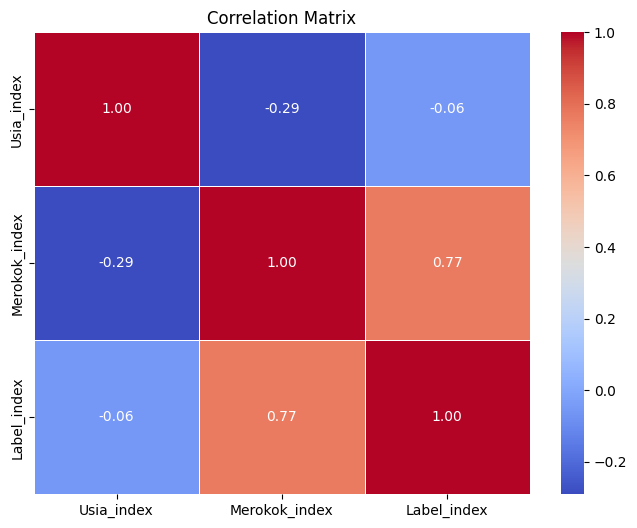

In [ ]:
#Matrik Korelasi
numeric_data = data_asli_encoded.select('Usia_index', 'Merokok_index', 'Label_index').toPandas()

# Calculate the correlation matrix using Pandas
correlation_matrix = numeric_data.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

##EDA##

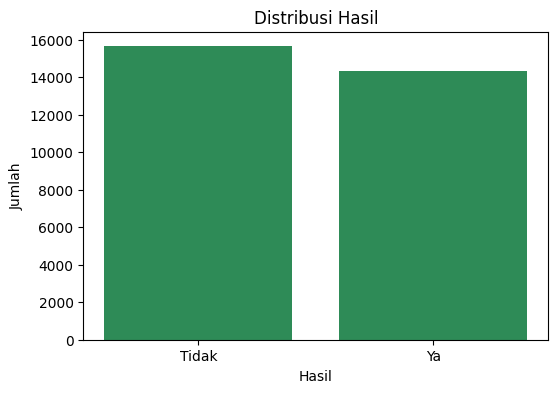

In [ ]:
# Distribusi kolom "label_index"
jenis_kelamin_counts = data_asli_encoded.groupBy("label_index").count().toPandas()

# Mapping label_index values to their corresponding categories ("Ya" and "Tidak")
label_mapping = {0: "Tidak", 1: "Ya"}

# Replace 'label_index' with the actual category names (Ya/Tidak)
jenis_kelamin_counts["label"] = jenis_kelamin_counts["label_index"].map(label_mapping)

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(jenis_kelamin_counts["label"], jenis_kelamin_counts["count"], color='seagreen')
plt.title("Distribusi Hasil")
plt.xlabel("Hasil")
plt.ylabel("Jumlah")
plt.show()


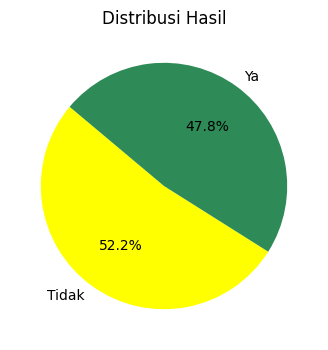

In [ ]:
# Distribusi kolom "hasil"
hasil_counts = data.groupBy("hasil").count().toPandas()
plt.figure(figsize=(6, 4))
plt.pie(hasil_counts["count"], labels=hasil_counts["hasil"], autopct="%1.1f%%", startangle=140, colors=['yellow', 'seagreen'])
plt.title("Distribusi Hasil")
plt.show()

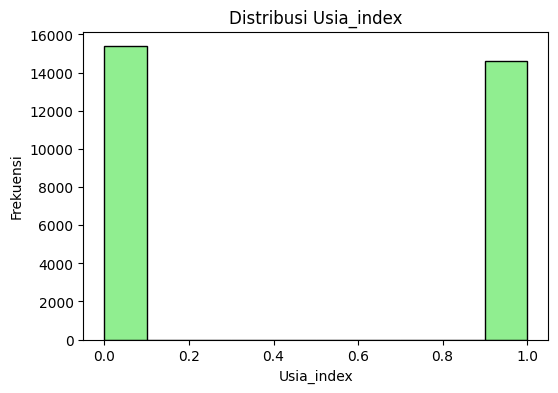

In [ ]:
# Histogram for 'Usia_index'
column = 'Usia_index'
plt.figure(figsize=(6, 4))

plt.hist(data.select(column).toPandas()[column].values, bins=10, color='lightgreen', edgecolor='black')

plt.title(f"Distribusi {column}")
plt.xlabel(column)
plt.ylabel("Frekuensi")
plt.show()

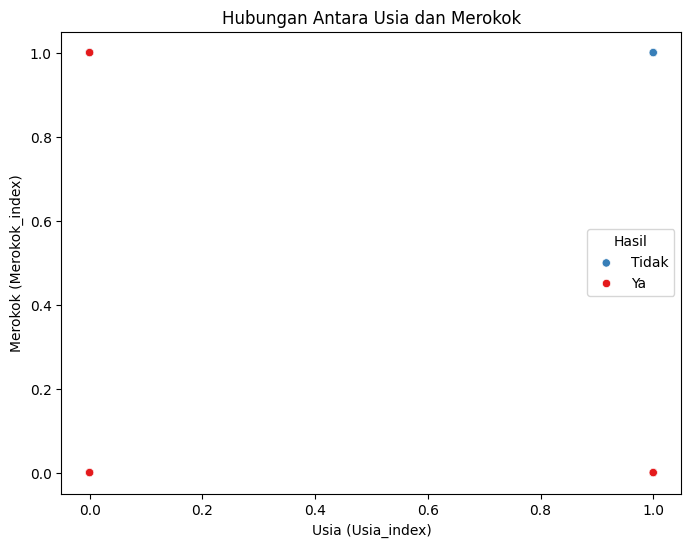

In [ ]:
# 4. Scatter plot for 'Usia_index' vs 'Merokok_index'
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Usia_index", y="Merokok_index", data=data_asli_encoded.toPandas(), hue="label_index", palette="Set1")
plt.title("Hubungan Antara Usia dan Merokok")
plt.xlabel("Usia (Usia_index)")
plt.ylabel("Merokok (Merokok_index)")
plt.legend(title='Hasil', labels=['Tidak', 'Ya'])
plt.show()


## Model Machine Learning ##

In [ ]:
from pyspark.sql.functions import col  # Import col function if not already

# Drop the existing 'features' column if it exists
if 'features' in data.columns:
    data = data.drop(col("features"))

# Apply the VectorAssembler to create the 'features' column
data = assembler.transform(data)



In [ ]:
from pyspark.ml.feature import StringIndexer

# Assuming 'hasil' is the target column
indexer = StringIndexer(inputCol="hasil", outputCol="hasil_index")
data = indexer.fit(data).transform(data)

# Now split the data
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
# Model Machine Learning
# Random Forest
rf = RandomForestClassifier(labelCol="hasil_index", featuresCol="features")
gbt = GBTClassifier(labelCol="hasil_index", featuresCol="features")
nb = NaiveBayes(labelCol="hasil_index", featuresCol="features")
svc = LinearSVC(labelCol="hasil_index", featuresCol="features")

In [ ]:
# Melatih dan Mengevaluasi Model
models = {"Random Forest": rf, "Gradient Boosted Tree": gbt, "Naive Bayes": nb, "Linear SVC": svc}
evaluator = BinaryClassificationEvaluator(labelCol="hasil_index")


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Melatih dan Mengevaluasi Model
models = {"Random Forest": rf, "Gradient Boosted Tree": gbt, "Naive Bayes": nb, "Linear SVC": svc}
# BinaryClassificationEvaluator for AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="hasil_index")
# MulticlassClassificationEvaluator for accuracy, recall, F1, precision
evaluator_multi = MulticlassClassificationEvaluator(labelCol="hasil_index", predictionCol="prediction")

for model_name, model in models.items():
    trained_model = model.fit(train_data)
    predictions = trained_model.transform(test_data)

    # Calculate AUC
    auc = evaluator_auc.evaluate(predictions)

    # Calculate accuracy, recall, F1, precision
    accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
    recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
    f1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
    precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})

    print(f"{model_name} Metrics:")
    print(f"  AUC: {auc:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print("-" * 20)  # Separator for better readability

Random Forest Metrics:
  AUC: 0.8857
  Accuracy: 0.8850
  Recall: 0.8850
  F1 Score: 0.8851
  Precision: 0.8858
--------------------
Gradient Boosted Tree Metrics:
  AUC: 0.9269
  Accuracy: 0.8850
  Recall: 0.8850
  F1 Score: 0.8851
  Precision: 0.8858
--------------------
Naive Bayes Metrics:
  AUC: 0.3347
  Accuracy: 0.8850
  Recall: 0.8850
  F1 Score: 0.8851
  Precision: 0.8858
--------------------
Linear SVC Metrics:
  AUC: 0.9269
  Accuracy: 0.8850
  Recall: 0.8850
  F1 Score: 0.8851
  Precision: 0.8858
--------------------


 ## Hyperparameter Tuning ##

Training Random Forest...


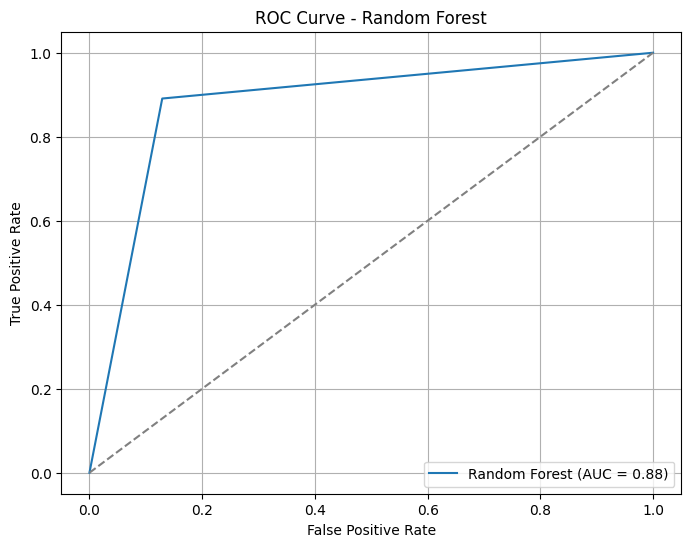

Training Gradient Boosted Trees...


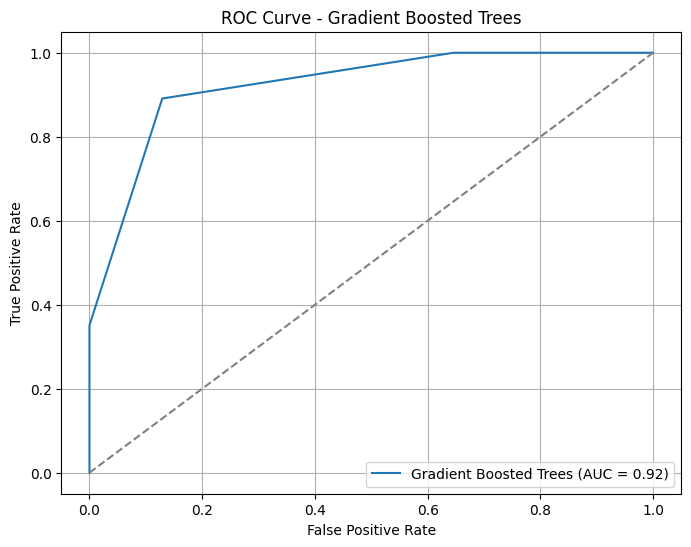

Training Naive Bayes...


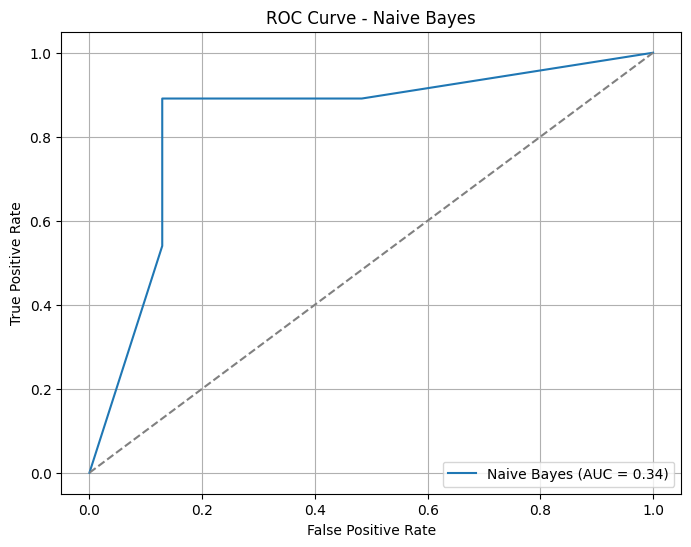

Training Linear SVC...
Model Performance (AUC):
Random Forest: AUC = 0.8809
Gradient Boosted Trees: AUC = 0.9229
Naive Bayes: AUC = 0.3422
Linear SVC: AUC = 0.9229


In [ ]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Split data into training and testing sets
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

# Define models
models = {
    "Random Forest": RandomForestClassifier(labelCol="hasil_index", featuresCol="features", numTrees=50),
    "Gradient Boosted Trees": GBTClassifier(labelCol="hasil_index", featuresCol="features", maxIter=100),
    "Naive Bayes": NaiveBayes(labelCol="hasil_index", featuresCol="features"),
    "Linear SVC": LinearSVC(labelCol="hasil_index", featuresCol="features")
}

# Initialize evaluator for AUC
evaluator = BinaryClassificationEvaluator(labelCol="hasil_index", metricName="areaUnderROC")

# Store results
model_results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    trained_model = model.fit(train_data)
    predictions = trained_model.transform(test_data)

    # Calculate AUC
    auc = evaluator.evaluate(predictions)
    model_results[model_name] = {"model": trained_model, "auc": auc}

    # Extract probabilities and labels for ROC Curve (only for models that support probability)
    if "probability" in predictions.columns:
        predictions_pandas = predictions.select("probability", "hasil_index").toPandas()
        y_prob = predictions_pandas["probability"].apply(lambda x: x[1]).values  # Extract second column (positive class)
        y_true = predictions_pandas["hasil_index"].values

        # Calculate ROC curve
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_true, y_prob)

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal
        plt.title(f"ROC Curve - {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

# Print AUC results for all models
print("Model Performance (AUC):")
for model_name, results in model_results.items():
    print(f"{model_name}: AUC = {results['auc']:.4f}")


In [ ]:
# Hyperparameter Tuning untuk 2 Model Terbaik
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50]).build()
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = crossval.fit(train_data)
bestModel = cvModel.bestModel

In [ ]:
# Menampilkan Hasil Terbaik
best_auc = evaluator.evaluate(bestModel.transform(test_data))

# Get the best model name based on AUC scores
best_model_name = max(model_results, key=lambda k: model_results[k]['auc'])
best_model_auc = model_results[best_model_name]['auc']

print(f"Best Model: {best_model_name}")
print(f"AUC Score: {best_model_auc:.4f}")

Best Model: Gradient Boosted Trees
AUC Score: 0.9229


Penjelasan No 1

Jumlah Data: Semua kolom memiliki 30.000 entri, tanpa data yang hilang.
<br>Kolom Numerik:<br>
- No: Hanya berfungsi sebagai nomor urut, nilai mulai dari 1 hingga 30.000.
<br>Kolom Kategori:<br>
- Usia: Terdapat dua kategori (Tua, Muda), dengan kategori Muda lebih dominan (15.383 entri).
- Jenis_Kelamin: Terdapat du kategori (Pria dan Wanita) Mayoritas adalah Wanita (22.225 entri, sekitar 74%).
- Merokok: Aktif (15.210 entri) dan Pasif (14.790 entri) memiliki distribusi yang cukup seimbang.
- Bekerja:(Ya atau Tidak) 18.964 individu bekerja (Ya).
- Rumah_Tangga: (Ya atau Tidak) 15.425 memiliki tanggungan rumah tangga (Ya).
- Aktivitas_Begadang: (Ya atau Tidak) Mayoritas begadang (Ya, 17.548 entri).
- Aktivitas_Olahraga: (Sering atau Jarang) Lebih banyak individu yang jarang olahraga (Jarang, 17.994 entri).
- Asuransi: (Ada atau Tidak) Sebagian besar memiliki asuransi (Ada, 21.239 entri).
- Penyakit_Bawaan: (Ada atau Tidak) 19.350 individu memiliki penyakit bawaan (Ada).
- Hasil: (Ya atau Tidak) Tidak tercapai pada 15.648 kasus (sekitar 52%).

Detail Informasi Dataset:

- Jumlah Data: 30.000 observasi.

- Tipe Data: Semua kolom kecuali "No" bertipe kategori (object).

- Periode Data: Tidak ada kolom eksplisit yang menyebutkan waktu; perlu dicek
jika ada keterkaitan waktu di metadata atau informasi lainnya.

- Sumber Data: Informasi sumber data belum terlihat secara eksplisit dari isi dataset ini.

Nilai Unik per Kolom

Semua kolom kategori memiliki dua nilai unik, menunjukkan sifat biner (ya/tidak atau kategori serupa).
